# DD2437
## Lab 1B - Part II

**Group 26**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt


In [ ]:
'''
Seting parameters as according to instructions.
'''
beta = 0.2
gamma = 0.1
n = 10
tau = 25 # tau > 17

In [ ]:
'''
We define the Mackey-Glass function as according
to the given formula and make use of the global
parameters defined.

'''
def generate_mackey_glass(limit=1505):
  mackey_glass_series = []
  mackey_glass_series.append(1.5)
  for t in range(0, limit):
    t_tau = t - tau
    if t_tau < 0:
      x_t_tau = 0
    else:
      x_t_tau = mackey_glass_series[t_tau]
    x_t = mackey_glass_series[t]
    x_t_1 = x_t + (beta * x_t_tau) / (1 + x_t_tau**n) - gamma * x_t
    mackey_glass_series.append(x_t_1)

  return  np.array(mackey_glass_series)

def get_mg_value(t):
    return mg_data[t]

mg_data = generate_mackey_glass()

In [ ]:
'''
Prepare a embedded time-lagged representation by picking
1200 points from t301 to 1500, which we will use for training,
validation, and testing.
'''
t_range = np.arange(301, 1501)
X = np.array([
    get_mg_value(t_range - 20),
    get_mg_value(t_range - 15),
    get_mg_value(t_range - 10),
    get_mg_value(t_range - 5),
    get_mg_value(t_range)
])

Y = get_mg_value(t_range + 5)

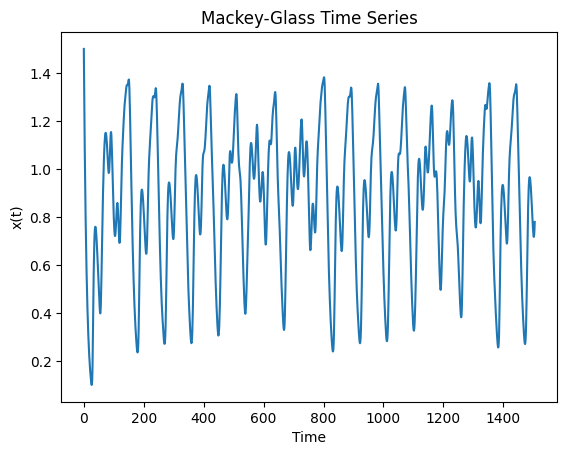

In [ ]:
'''
We plot the time series for a better understainding of the data.
'''

plt.plot(mg_data)
plt.title('Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.show()

In [ ]:
'''
Explore the data in order to get a better understanding and
double check that it is correct.
'''
print(X.shape)
print(Y.shape)
print(X[:, :5])
print(Y[:5])

(5, 1200)
(1200,)
[[0.8944555  0.92100416 0.93702004 0.94416741 0.94402257]
 [0.93800067 0.92730868 0.91291144 0.89552381 0.87565652]
 [0.8537292  0.83021651 0.80575843 0.78121215 0.75769004]
 [0.73662456 0.71986036 0.70972683 0.70897191 0.72036821]
 [0.74588625 0.78564711 0.83700733 0.89413961 0.94921825]]
[0.99567019 1.03083227 1.05574157 1.07331517 1.08680026]


Shapes does seem to check out, though ght other values are yet unclear.

In [ ]:
'''
We split up the dataset into training, validation, and testing sets
but wihtout shuffling in order to keep the ordering of the data.
'''
X_train = X[:, :800]
Y_train = Y[:800]

X_val = X[:, 800:1000]
Y_val = Y[800:1000]

X_test = X[:, 1000:]
Y_test = Y[1000:]

#print(X_train.shape, Y_train.shape)
#print(X_val.shape, Y_val.shape)
#print(X_test.shape, Y_test.shape)

## 4.2 First part

In [ ]:
'''
Then we setup the training process with batch learning and
early stopping in order to prevent overfitting and base it on
the validation loss.
'''
def train_model(model, X_train, Y_train, X_val, Y_val, lr=0.001):
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    history = model.fit(
        X_train.T,
        Y_train,
        validation_data=(X_val.T, Y_val),
        epochs=256,
        batch_size=16,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
        ],
        verbose=0
    )
    return history

In [ ]:
'''
Helper function to plot the training and validation loss over epochs.
'''
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
'''
Wrapper function for training, plotting history, and
evaluating the model on the test set.
'''
def train_and_evaluate(model, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    history = train_model(model, X_train, Y_train, X_val, Y_val)
    plot_history(history)
    validation_loss = model.evaluate(X_val.T, Y_val, verbose=0)
    test_loss = model.evaluate(X_test.T, Y_test, verbose=0)
    print(f'Validation Loss: {validation_loss:.4f}')
    print(f'Test Loss: {test_loss:.4f}')


In [ ]:
'''
Now we setup the network structure as instruced:
5 input neurons and 1 output neuron.

Note that were using sigmoid activation for the hidden layer and
linear activation for the output layer as instructed.
'''
model = Sequential([
    Input(shape=(5,)),
    Dense(
        5,
        activation='sigmoid',
        kernel_regularizer=l2(1e-4)
    ),
    Dense(1, activation='linear')
])

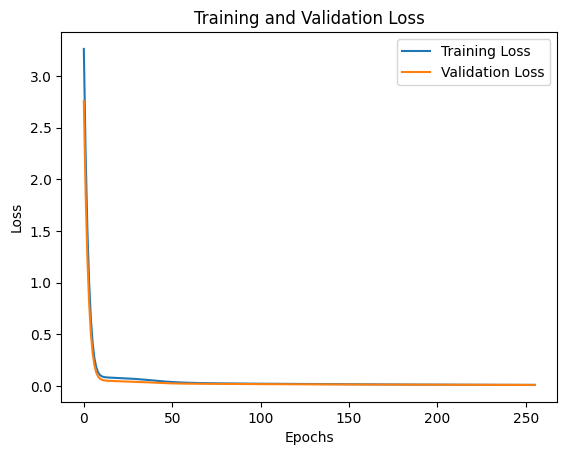

Test Loss: 0.0126


In [ ]:
train_and_evaluate(model, X_train, Y_train, X_val, Y_val, X_test, Y_test)

Using batch size = 16, and ADAM for adjusting learning rate. The tests were run 5 times each.

No L2: val_loss=578

L2 (1e*4): val_loss=583

L1 (1e*4): val_loss=708

Meaning in this limited amount of tests, we found that no weight regularization or L2 (ridge) perfomre better than L1. This is likely due to L2 enforcing smooth small weights (and not sparsity), which is helpful in this case as there are so few weights in total due to the small network size. In addition, all the data feed to the network [x(t−20),x(t−15),x(t−10),x(t−5),x(t)] are important, thus sparsity would ruin the calculations.

###TODO Maybe still think a bit more about regularizers

## 4.2 Second part

In [ ]:
def create_model(nh1, nh2, reg_lambda=1e-4):
  model = Sequential([
    Input(shape=(5,)),
    Dense(
        nh1,
        activation='sigmoid',
        kernel_regularizer=l2(reg_lambda)
    ),
    Dense(
        nh2,
        activation='sigmoid',
        kernel_regularizer=l2(reg_lambda)
    ),
    Dense(1, activation='linear')
  ])
  return model

Epoch 1/256
50/50 - 2s - 39ms/step - loss: 0.4147 - val_loss: 0.2021
Epoch 2/256
50/50 - 0s - 4ms/step - loss: 0.1907 - val_loss: 0.0891
Epoch 3/256
50/50 - 0s - 4ms/step - loss: 0.1164 - val_loss: 0.0590
Epoch 4/256
50/50 - 0s - 4ms/step - loss: 0.0956 - val_loss: 0.0533
Epoch 5/256
50/50 - 0s - 4ms/step - loss: 0.0908 - val_loss: 0.0529
Epoch 6/256
50/50 - 0s - 4ms/step - loss: 0.0894 - val_loss: 0.0528
Epoch 7/256
50/50 - 0s - 4ms/step - loss: 0.0887 - val_loss: 0.0530
Epoch 8/256
50/50 - 0s - 4ms/step - loss: 0.0881 - val_loss: 0.0524
Epoch 9/256
50/50 - 0s - 4ms/step - loss: 0.0873 - val_loss: 0.0518
Epoch 10/256
50/50 - 0s - 5ms/step - loss: 0.0867 - val_loss: 0.0513
Epoch 11/256
50/50 - 0s - 4ms/step - loss: 0.0858 - val_loss: 0.0507
Epoch 12/256
50/50 - 0s - 5ms/step - loss: 0.0849 - val_loss: 0.0501
Epoch 13/256
50/50 - 0s - 5ms/step - loss: 0.0840 - val_loss: 0.0498
Epoch 14/256
50/50 - 0s - 4ms/step - loss: 0.0829 - val_loss: 0.0489
Epoch 15/256
50/50 - 0s - 4ms/step - loss:

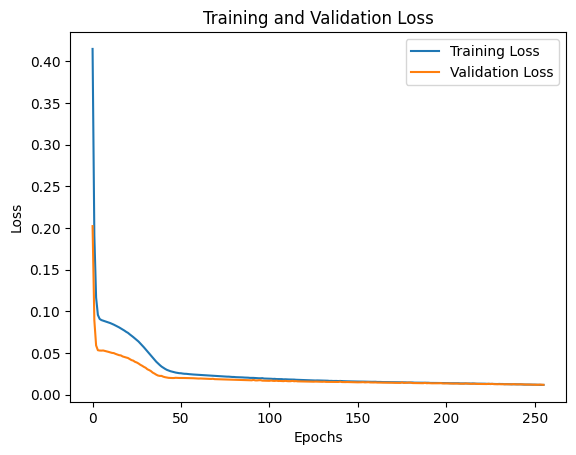

Validation Loss: 0.0118
Test Loss: 0.0130


In [ ]:
model=create_model(4,6)
train_and_evaluate(model, X_train, Y_train, X_val, Y_val, X_test, Y_test)

##4.3

Model with nh1= 3 and nh2= 2


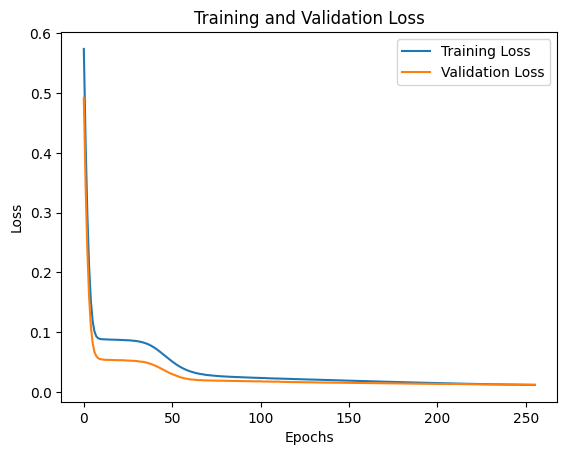

Validation Loss: 0.0121
Test Loss: 0.0133
Model with nh1= 3 and nh2= 4


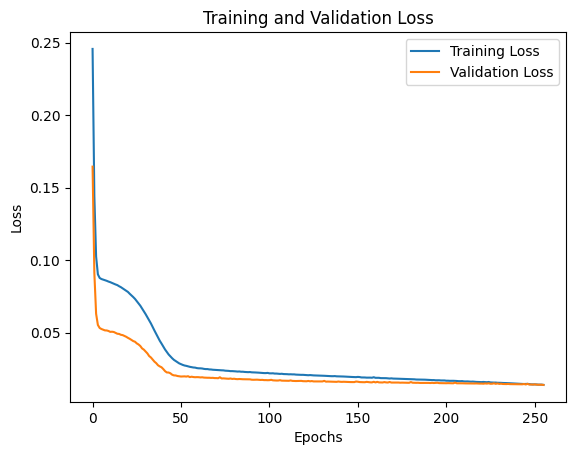

Validation Loss: 0.0138
Test Loss: 0.0157
Model with nh1= 3 and nh2= 6


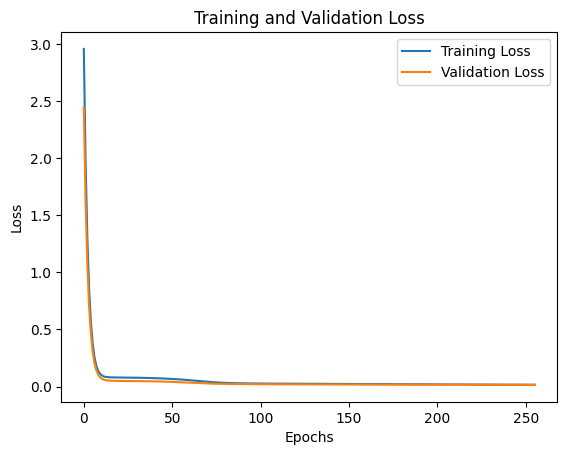

Validation Loss: 0.0139
Test Loss: 0.0185
Model with nh1= 4 and nh2= 2


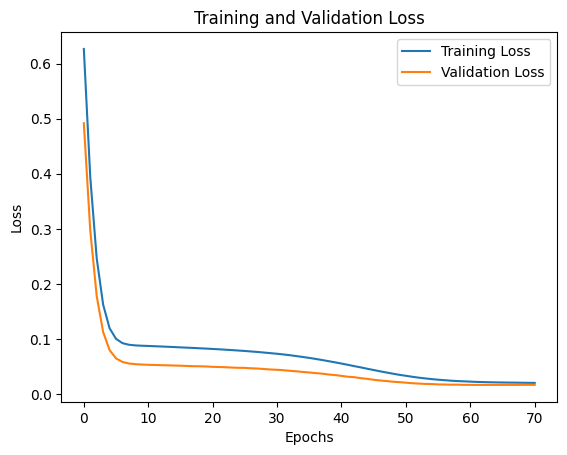

Validation Loss: 0.0166
Test Loss: 0.0261
Model with nh1= 4 and nh2= 4


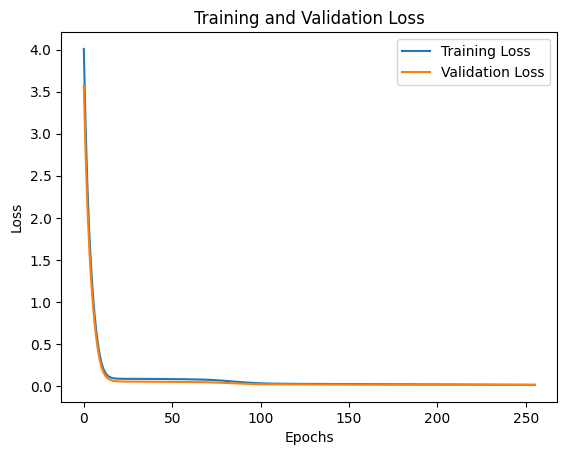

Validation Loss: 0.0133
Test Loss: 0.0169
Model with nh1= 4 and nh2= 6


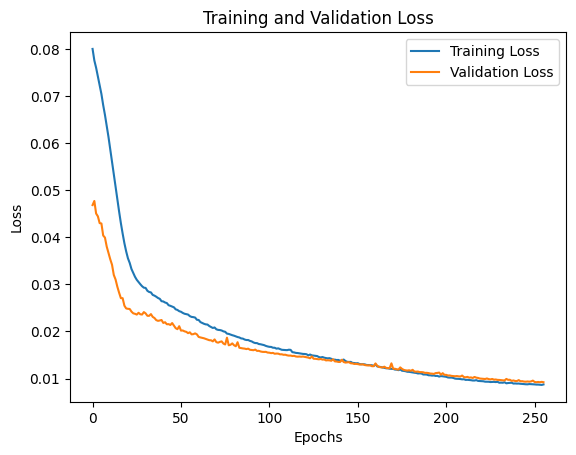

Validation Loss: 0.0092
Test Loss: 0.0094
Model with nh1= 5 and nh2= 2


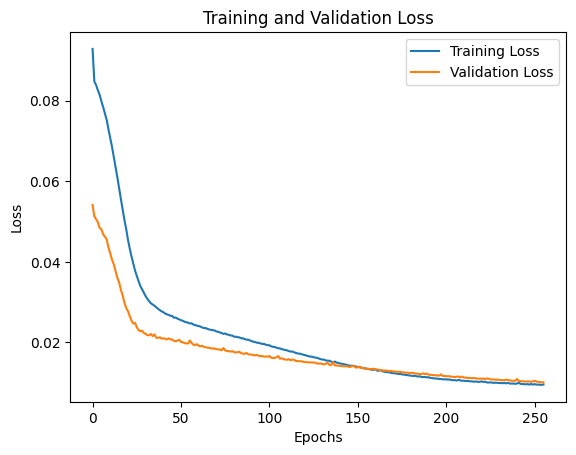

Validation Loss: 0.0101
Test Loss: 0.0102
Model with nh1= 5 and nh2= 4


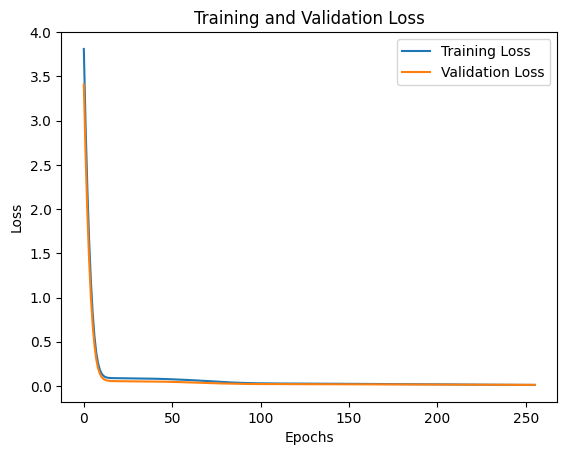

Validation Loss: 0.0123
Test Loss: 0.0127
Model with nh1= 5 and nh2= 6


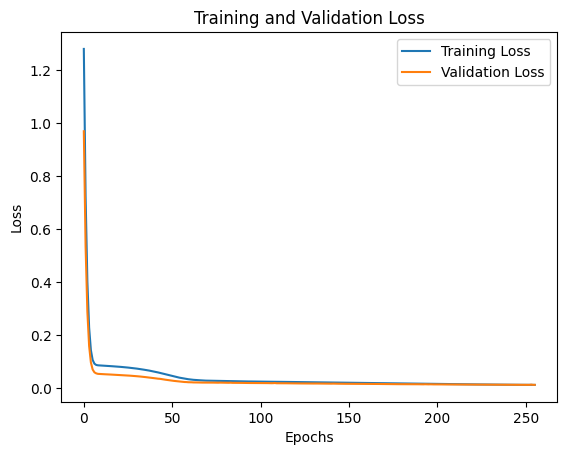

Validation Loss: 0.0120
Test Loss: 0.0133


In [ ]:
nh1 = {3,4,5}
nh2 = {2,4,6}

for n1 in nh1:
  for n2 in nh2:
    print("Model with nh1=", n1, "and nh2=", n2)
    model = create_model(n1, n2)
    train_and_evaluate(model, X_train, Y_train, X_val, Y_val, X_test, Y_test)

Best model by validation error nh1=4 nh2=6 (0.0092), and worst nh1=4 and nh2=2 (0.0166).
The test loss for the first was 0.0094 and for the second 0.0261.


## 4.


Model with nh1= 4 and nh2= 9 reg= 0.0001 .And noise with sigma= 0.05


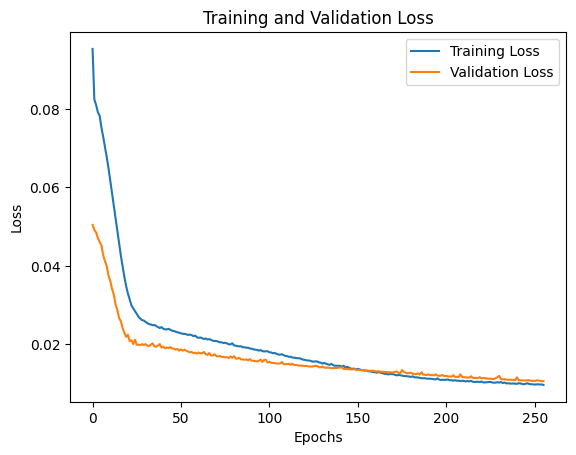

Validation Loss: 0.0106
Test Loss: 0.0106
Model with nh1= 4 and nh2= 3 reg= 0.0001 .And noise with sigma= 0.05


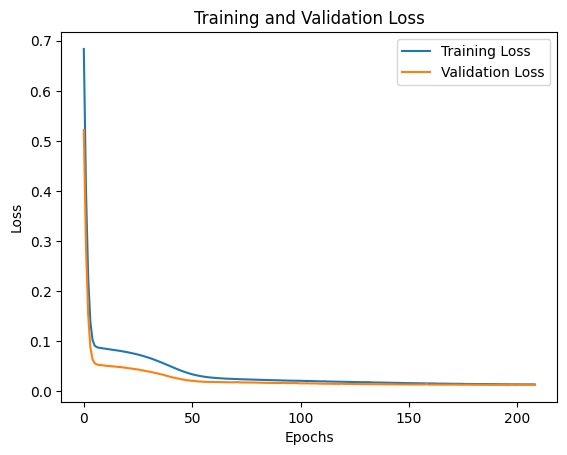

Validation Loss: 0.0130
Test Loss: 0.0165
Model with nh1= 4 and nh2= 6 reg= 0.0001 .And noise with sigma= 0.05


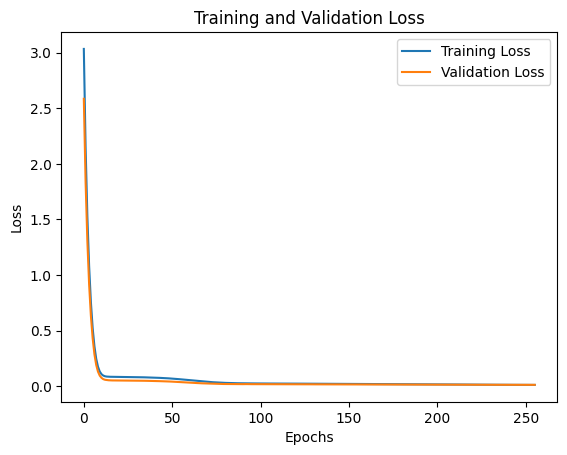

Validation Loss: 0.0129
Test Loss: 0.0136
Model with nh1= 4 and nh2= 9 reg= 0.01 .And noise with sigma= 0.05


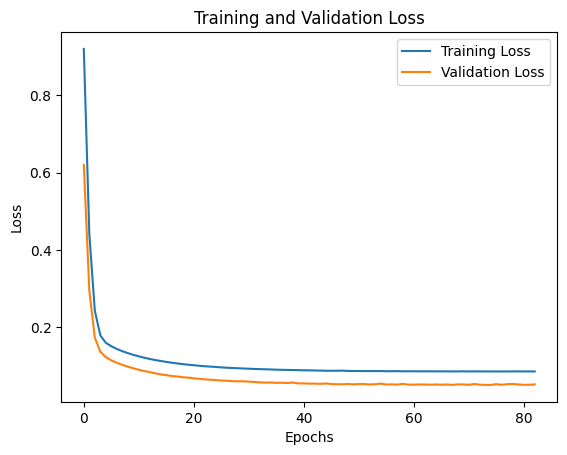

Validation Loss: 0.0514
Test Loss: 0.1002
Model with nh1= 4 and nh2= 3 reg= 0.01 .And noise with sigma= 0.05


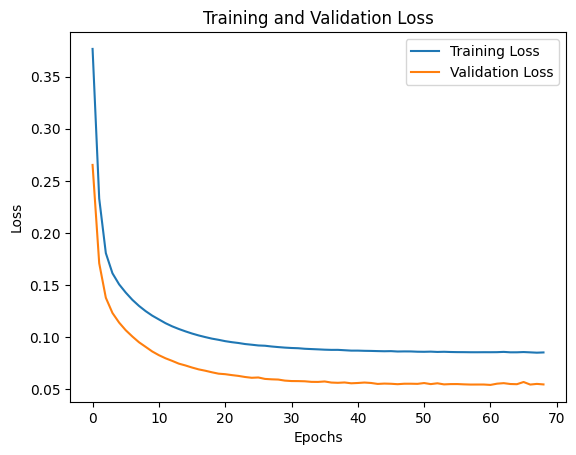

Validation Loss: 0.0541
Test Loss: 0.0984
Model with nh1= 4 and nh2= 6 reg= 0.01 .And noise with sigma= 0.05


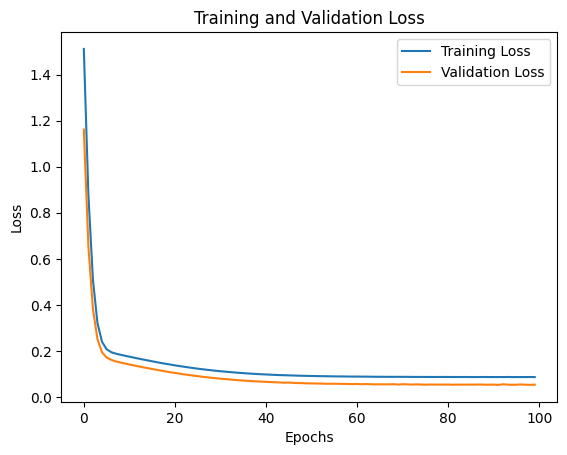

Validation Loss: 0.0524
Test Loss: 0.1005
Model with nh1= 4 and nh2= 9 reg= 0.001 .And noise with sigma= 0.05


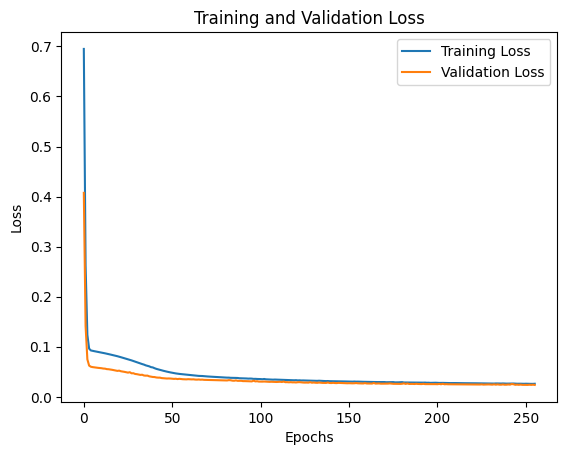

Validation Loss: 0.0238
Test Loss: 0.0283
Model with nh1= 4 and nh2= 3 reg= 0.001 .And noise with sigma= 0.05


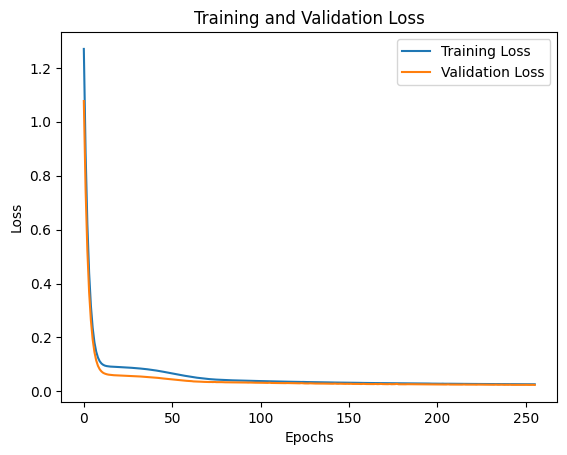

Validation Loss: 0.0241
Test Loss: 0.0289
Model with nh1= 4 and nh2= 6 reg= 0.001 .And noise with sigma= 0.05


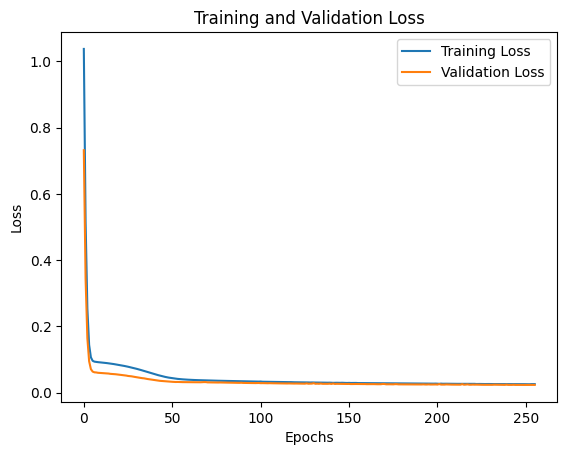

Validation Loss: 0.0235
Test Loss: 0.0279
Model with nh1= 4 and nh2= 9 reg= 0.0001 .And noise with sigma= 0.15


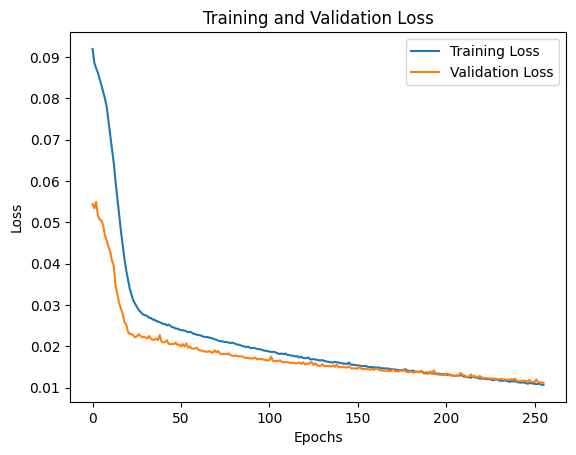

Validation Loss: 0.0112
Test Loss: 0.0118
Model with nh1= 4 and nh2= 3 reg= 0.0001 .And noise with sigma= 0.15


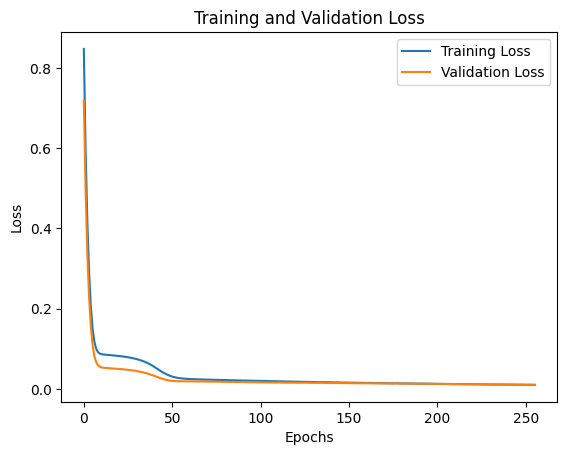

Validation Loss: 0.0106
Test Loss: 0.0112
Model with nh1= 4 and nh2= 6 reg= 0.0001 .And noise with sigma= 0.15


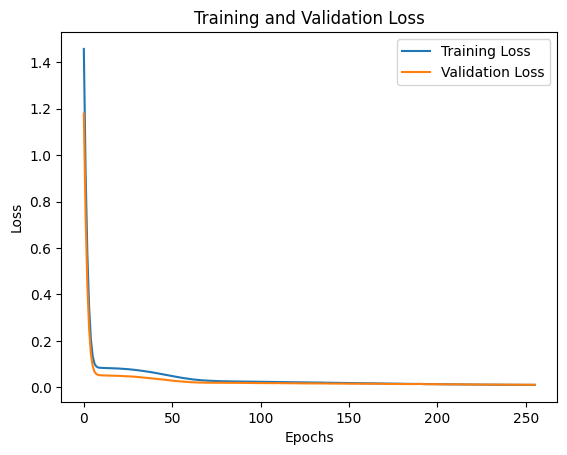

Validation Loss: 0.0107
Test Loss: 0.0110
Model with nh1= 4 and nh2= 9 reg= 0.01 .And noise with sigma= 0.15


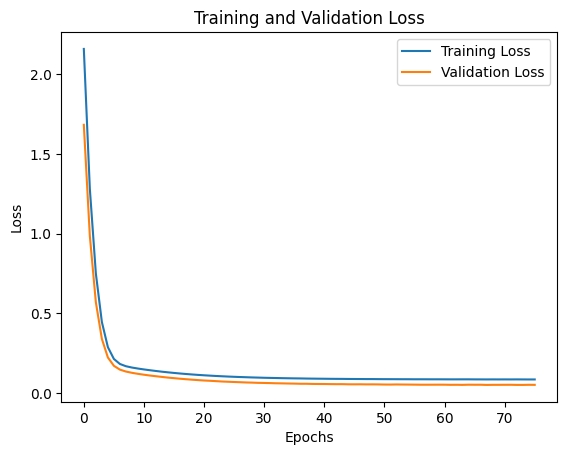

Validation Loss: 0.0521
Test Loss: 0.1010
Model with nh1= 4 and nh2= 3 reg= 0.01 .And noise with sigma= 0.15


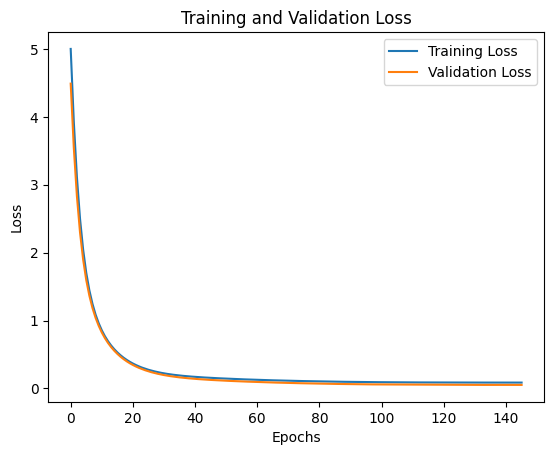

Validation Loss: 0.0515
Test Loss: 0.0995
Model with nh1= 4 and nh2= 6 reg= 0.01 .And noise with sigma= 0.15


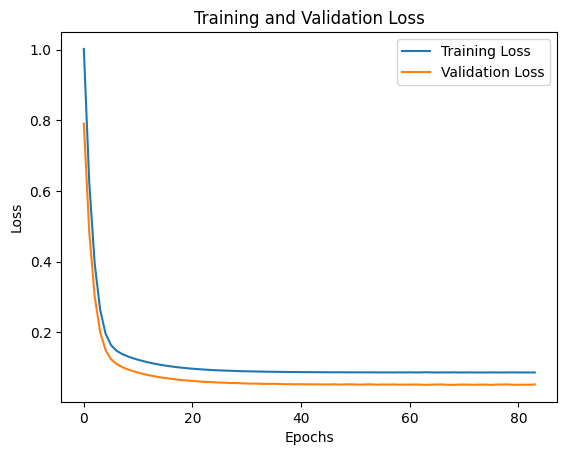

Validation Loss: 0.0508
Test Loss: 0.1019
Model with nh1= 4 and nh2= 9 reg= 0.001 .And noise with sigma= 0.15


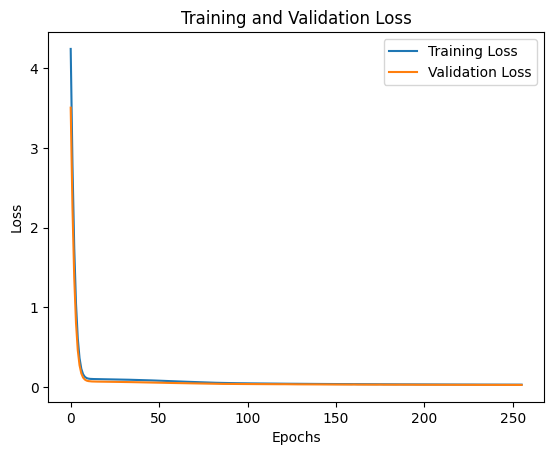

Validation Loss: 0.0250
Test Loss: 0.0314
Model with nh1= 4 and nh2= 3 reg= 0.001 .And noise with sigma= 0.15


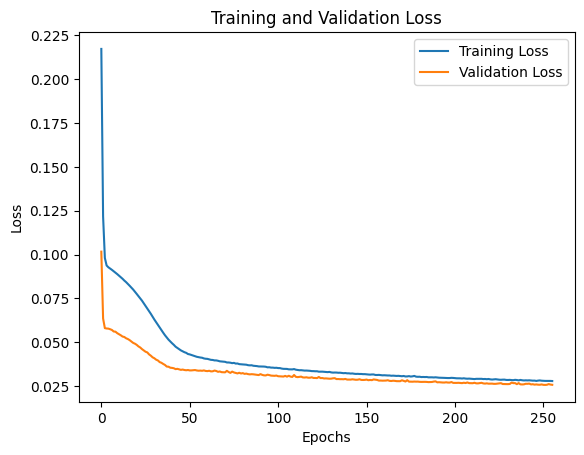

Validation Loss: 0.0257
Test Loss: 0.0303
Model with nh1= 4 and nh2= 6 reg= 0.001 .And noise with sigma= 0.15


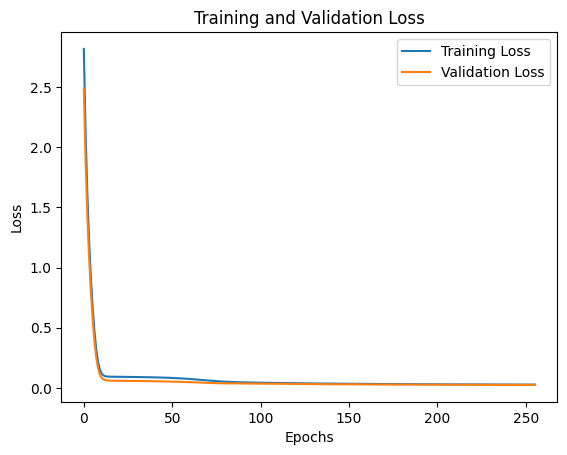

Validation Loss: 0.0251
Test Loss: 0.0306


In [ ]:
sigma={0.05, 0.15}
opt_nh1=4
nh2= {3,6,9}
regulariztion ={1e-2, 1e-3, 1e-4}
for sig in sigma:
  noise = np.random.normal(loc=0, scale= sig, size=len(Y_train))
  X_train_noisy = X_train + noise
  for reg in regulariztion:
    for n2 in nh2:
      print("Model with nh1 =", opt_nh1, "and nh2 =", n2, "reg =", reg, ".And noise with sigma =", sig )
      model = create_model(opt_nh1, n2, reg)
      train_and_evaluate(model, X_train, Y_train, X_val, Y_val, X_test, Y_test)